Pytorch CIFAR10 Tutorial

Specifically for `vision`, we have created a package called `torchvision`, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., `torchvision.datasets` and `torch.utils.data.DataLoader`.

For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![](http://pytorch.org/tutorials/_images/cifar10.png)


Training an image classifier

We will do the following steps in order:
1. Load and normalize the CIFAR10 training and test datsets using `torchvision`
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

In [2]:
# 1. Load and normalize CIFAR10

import torch
import torchvision
import torchvision.transforms as transforms

# The output of torchvision datasets are PILImage images of range [0,1].
# We transform them into Tensors of normalized range [-1,1]

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                     download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
          'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


  cat  bird   dog  deer


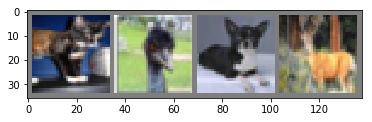

In [4]:
# Show some training images for fun
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
# 2. Define a CNN

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [6]:
# 3. Define a loss function and optimizer
# use classification cross-entropy loss and SGD with momentum

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
# 4. Train the network

# Loop over our data iterator, and feed the inputs to the network and optimize

for epoch in range(2): # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print stats
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.180
[1,  4000] loss: 1.853
[1,  6000] loss: 1.683
[1,  8000] loss: 1.606
[1, 10000] loss: 1.524
[1, 12000] loss: 1.486
[2,  2000] loss: 1.399
[2,  4000] loss: 1.359
[2,  6000] loss: 1.349
[2,  8000] loss: 1.320
[2, 10000] loss: 1.284
[2, 12000] loss: 1.263
Finished Training


GroundTruth:    cat  ship  ship plane


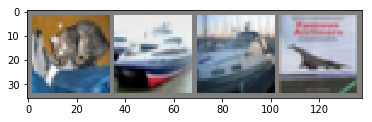

In [8]:
# 5. Test the network on the test data

# We trained the CNN for 2 passes over the training dataset
# Check CNN by predicting the class label that the NN outputs against ground truth
#  If the prediction is correct, we add the sample to the list of correct predictions.

# first display an image from the test set to get familiar

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
outputs = net(Variable(images))

The outputs are energies for the 10 classes. Higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [10]:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j][0]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


In [11]:
# Check CNN performance on whole dataset
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [12]:
# What are the classes that performed well and classes that did not perform well:

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 68 %
Accuracy of   car : 77 %
Accuracy of  bird : 27 %
Accuracy of   cat : 24 %
Accuracy of  deer : 37 %
Accuracy of   dog : 41 %
Accuracy of  frog : 75 %
Accuracy of horse : 67 %
Accuracy of  ship : 73 %
Accuracy of truck : 60 %
